In [31]:
# FINAL PROJECT EMISSIONS #

# importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.mplot3d import Axes3D
from openpyxl import load_workbook

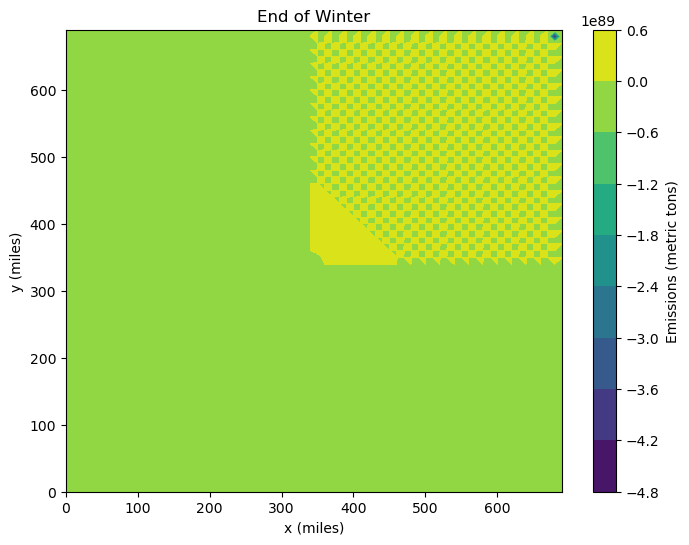

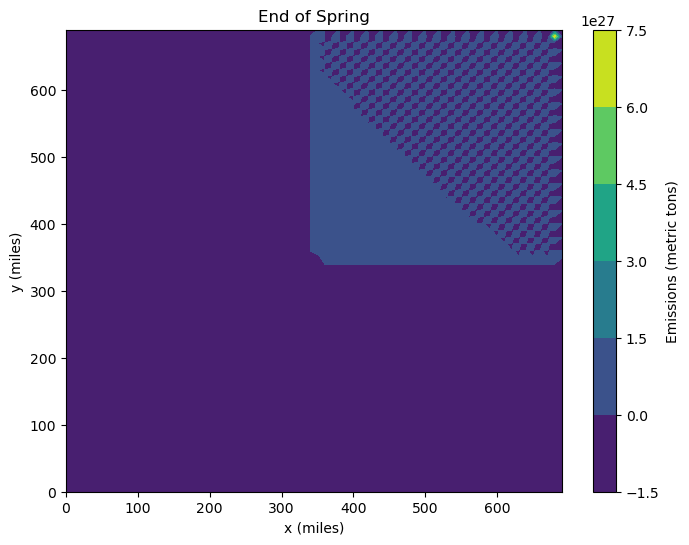

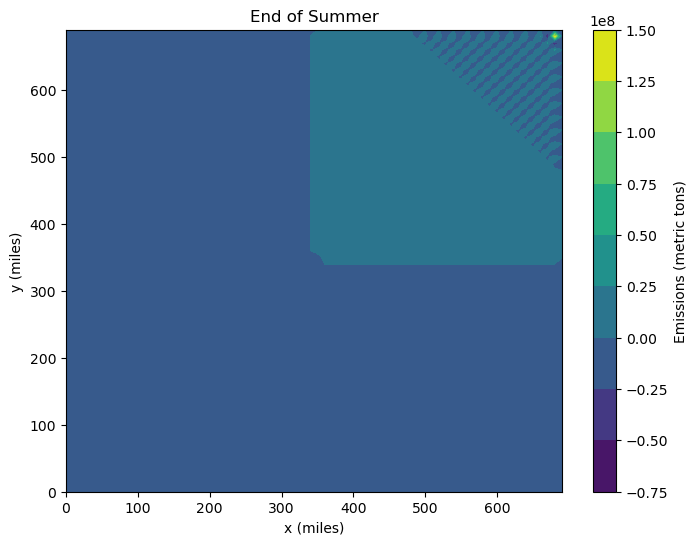

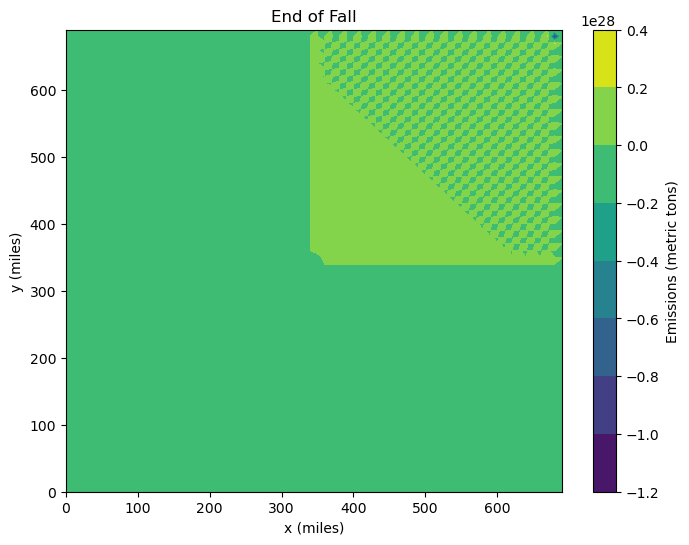

In [33]:
# importing excel workbook
file_path = "/Users/samthanassi/Library/Containers/com.microsoft.Excel/Data/Downloads/2023_data_summary_spreadsheets/ghgp_data_by_year_2023.xlsx"
wb = load_workbook(file_path)
sheet = wb['Onshore Oil & Gas Prod.']
total_emissions_2023 = sheet['N6'].value

### INITIAL CONDITIONS

# setting up grid
nx = 70 # miles
ny = 70 # miles

# distance step in x and y direction
dx = 10 # miles
dy = 10 # miles

# creating a range and z and 2D meshgrid
z = np.zeros(nx * ny)
x = np.arange(0, nx*dx, dx) # creates the 1-D array of x positions
y = np.arange(0, ny*dy, dy) # creates the 1-D array of y positions
X, Y = np.meshgrid(x, y, indexing = 'ij') # creates a 2-D coordinate system for plotting

# setting value for hourly emissions
emissions_per_hour = total_emissions_2023 / (12 * 30.5 * 24) # metric tons per hour

"""
capital letters = 2D array
lowercase = 1D array
"""

# wind speeds, the advection coefficients, 4 values, one for each season
u = 9.7 # wind in mph, dec - feb
ux = 9.7
uy = 9.7
u2 = 8.3 # wind in mph, mar - may
ux2 = 8.3
uy2 = 8.3
u3 = 6.9 # wind in mph, jun - aug
ux3 = 6.9
uy3 = 6.9
u4 = 8.3 # wind in mph, sep - nov
ux4 = 8.3
uy4 = 8.3

# creating time step
dt = 1 # hour

# creating seasons
three_months = 3 * 30.5 * 24 # 3 months, 30.5 days a month average, 24 hours a day = total hours for 3 months

# setting up time loop for one year
totaltime = 4 * three_months # one year full loop

# initial time
time = 0

# initial location to center denver
initial_x = nx // 2
initial_y = ny // 2

# creating a function to create and update the A matrix with wind values for each season
def update_A_matrix(ux, uy):
    cx = dt * np.abs(ux) / dx
    cy = dt * np.abs(uy) / dy  
    # test if cx and cy are stable
    if cx > 1:
        print('x is unstable')
        sys.exit()
    elif cy > 1:
        print('y is unstable')
        sys.exit()
        
    A = np.zeros((nx*ny, nx*ny))  # A matrix creation
    for i in range(nx):
        for k in range(ny):
            ik = i * ny + k
            if i == 0 or k == 0:  # Boundary conditions
                A[ik, ik] = 1
            elif i == nx-1 or k == ny-1:
                A[ik, ik] = 1
            else:  # Interior points
                A[ik, ik] = 1 - cx - cy
                A[ik, (i - 1) * ny + k] = cx
                A[ik, i * ny + k - 1] = cy
                """
                if ux > 0:
                    A[ik, (i - 1) * ny + k] = cx
                elif ux < 0:
                    A[ik, (i + 1) * ny + k] = cx

                if uy > 0:
                    A[ik, i * ny + k - 1] = cy
                elif uy < 0:
                    A[ik, i * ny + k + 1] = cy
                    """
              
    return A


# Initial A matrix for the first season
A = update_A_matrix(ux, uy)

# Time loop with shifting wind conditions
while time <= totaltime:
    # generate random number to determine which wind direction
    wind_direction = np.random.random()
    # Determine the current season based on time
    if time < three_months:    # Winter
        # Winter wind values
        if wind_direction <=.62:
            
            ux = -1*u  # move west
        elif .62 < wind_direction <=.73:
            #emission_movement_y = -uy 
            uy = -1*u # move south
        elif .73 < wind_direction <=.82:
            #emission_movement_x = ux
            ux = u # move east
        elif .82 < wind_direction <=1:
            #emission_movement_y = uy
            uy = u # move north
        A = update_A_matrix(ux, uy)
    elif time < 2 * three_months:   # Spring
        # Spring wind values
        if wind_direction <=.43:
            #emission_movement_x = -u2
            ux2 = -1*u2  # move west
        elif .43 < wind_direction <=.58:
            #emission_movement_y = -u2
            uy2 = -1*u2  # move south
        elif .58 < wind_direction <=.74:
            #emission_movement_x = u2
            ux2 = u2  # move east
        elif .74 < wind_direction <=1:
            #emission_movement_y = u2
            uy2 = u2  # move north
        A = update_A_matrix(ux2, uy2)
    elif time < 3 * three_months:   # Summer
        # Summer wind values
        if wind_direction <=.36:
            #emission_movement_x = -u3
            ux3 = -1*u3  # move west
        elif .36 < wind_direction <=.55:
            #emission_movement_y = -u3
            uy3 = -1*u3  # move south
        elif .55 < wind_direction <=.81:
            #emission_movement_x = u3
            ux3 = u3  # move east
        elif .81 < wind_direction <=1:
            #emission_movement_y = u3
            uy3 = u3  # move north
        A = update_A_matrix(ux3, uy3)
    else:  # Fall
        # Fall wind values
        if wind_direction <=.5:
            #emission_movement_x = -u4
            ux4 = -1*u4  # move west
        elif .5 < wind_direction <=.63:
            #emission_movement_y = -u4
            uy4 = -1*u4  # move south
        elif .63 < wind_direction <=.79:
            #emission_movement_x = u4
            ux4 = u4  # move east
        elif .79 < wind_direction <=1:
            #emission_movement_y = u4
            uy4 = u4  # move north
        A = update_A_matrix(ux4, uy4)

    
    # emitting from Denver at the center
    z[initial_x * ny + initial_y] += emissions_per_hour

    # moving the emissions based on the wind
    newz = np.dot(A, z)
    z[:] = newz

    # creating plots for each season or 3 month time step
    if time == three_months:
        plt.figure(figsize=(8, 6))  # figure size
        plt.contourf(X, Y, z.reshape(nx, ny), cmap='viridis')  # plotting the 2d aspects
        plt.colorbar(label='Emissions (metric tons)')  # creating colorbar
        plt.title('End of Winter')  # creating title
        plt.xlabel('x (miles)')  # creating x axis label
        plt.ylabel('y (miles)')  # creating y axis label
        plt.show()  # printing plot
    elif time == three_months * 2:
        plt.figure(figsize=(8, 6))
        plt.contourf(X, Y, z.reshape(nx, ny), cmap='viridis')
        plt.colorbar(label='Emissions (metric tons)')
        plt.title('End of Spring')
        plt.xlabel('x (miles)')
        plt.ylabel('y (miles)')
        plt.show()
    elif time == three_months * 3:
        plt.figure(figsize=(8, 6))
        plt.contourf(X, Y, z.reshape(nx, ny), cmap='viridis')
        plt.colorbar(label='Emissions (metric tons)')
        plt.title('End of Summer')
        plt.xlabel('x (miles)')
        plt.ylabel('y (miles)')
        plt.show()
    elif time == three_months * 4:
        plt.figure(figsize=(8, 6))
        plt.contourf(X, Y, z.reshape(nx, ny), cmap='viridis')
        plt.colorbar(label='Emissions (metric tons)')
        plt.title('End of Fall')
        plt.xlabel('x (miles)')
        plt.ylabel('y (miles)')
        plt.show()

    # increase time by an hour 
    time += 1

